# Purpose

The main objective of this notebook is to analyze the errors of our models and apply stacking techniques & making a prediction.

# Libraries

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
pd.options.display.float_format = '{:.9f}'.format
pd.options.display.max_columns = None
pd.set_option('display.max_colwidth', None)
from typing import List, Dict
from tqdm import tqdm
import joblib

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import warnings

from scipy.stats import skew, probplot
import statsmodels.api as sm


from sklearn.model_selection import KFold, GridSearchCV, train_test_split, cross_val_score, ParameterGrid, cross_val_predict
from sklearn.svm import SVR, LinearSVR
from sklearn.linear_model import Lasso, Ridge, LinearRegression, LassoCV, RidgeCV, ElasticNet
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, PolynomialFeatures, OneHotEncoder, OrdinalEncoder, \
                                  FunctionTransformer, PowerTransformer, RobustScaler, MaxAbsScaler,  KBinsDiscretizer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.feature_selection import mutual_info_regression, mutual_info_classif, SelectKBest, f_regression, chi2
from statsmodels.formula.api import ols
import statsmodels.api as sm
import statsmodels.formula.api as smf
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin, clone
from sklearn.compose import ColumnTransformer
from sklearn.metrics import make_scorer, mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, GradientBoostingRegressor, AdaBoostRegressor
from catboost import CatBoostRegressor
import xgboost as xgb
from xgboost import XGBRegressor
import lightgbm as lgb

import sys
import os
sys.path.append(os.path.abspath('../Scripts'))
from Functions.errors import *



# Reading the data and the models we already trained.

In [2]:
X_train = pd.read_csv('..//data//filtered_data//train_filtered.csv')
X_train = X_train.iloc[:, 1:]
y_train = X_train.pop('SalePrice')
#X_train.head()

In [3]:
models = {}
non_linear = {}
models_params = {}
for file_ in os.listdir('..//data//models_trained//'):
    name = file_.replace('best_', '').replace('.pkl', '')

    path_ = os.path.join('..//data//models_trained//', file_)
    with open(path_, 'rb') as f:
        model = joblib.load(f)
        models_params[name] = model.get_params()
        if name in ['ridge', 'lasso', 'svr', 'knn']:
            models[name] = model
        else:
            non_linear[name] = model
print(models.keys())
print(non_linear.keys())
print(models_params)

dict_keys(['knn', 'lasso', 'ridge', 'svr'])
dict_keys(['ada', 'gdb', 'lgbm', 'rf', 'xgb'])
{'ada': {'estimator__ccp_alpha': 0.0, 'estimator__criterion': 'squared_error', 'estimator__max_depth': 16, 'estimator__max_features': 'sqrt', 'estimator__max_leaf_nodes': None, 'estimator__min_impurity_decrease': 0.0, 'estimator__min_samples_leaf': 1, 'estimator__min_samples_split': 2, 'estimator__min_weight_fraction_leaf': 0.0, 'estimator__monotonic_cst': None, 'estimator__random_state': 2025, 'estimator__splitter': 'best', 'estimator': DecisionTreeRegressor(max_depth=16, max_features='sqrt', random_state=2025), 'learning_rate': 0.7082701941840128, 'loss': 'linear', 'n_estimators': 455, 'random_state': None}, 'gdb': {'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.03366859496434412, 'loss': 'squared_error', 'max_depth': 5, 'max_features': 'log2', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 5, 'min_samples_split': 4, 'min

# Residuals of our models

The concept is to create a scatterplot using the predictions from the models and plot them against the actual predictions to identify patterns and understand the model errors.

Additionally, we generated a QQ plot which arranges and graphs the residuals. Its objective is to verify if the residuals follow a normal distribution.

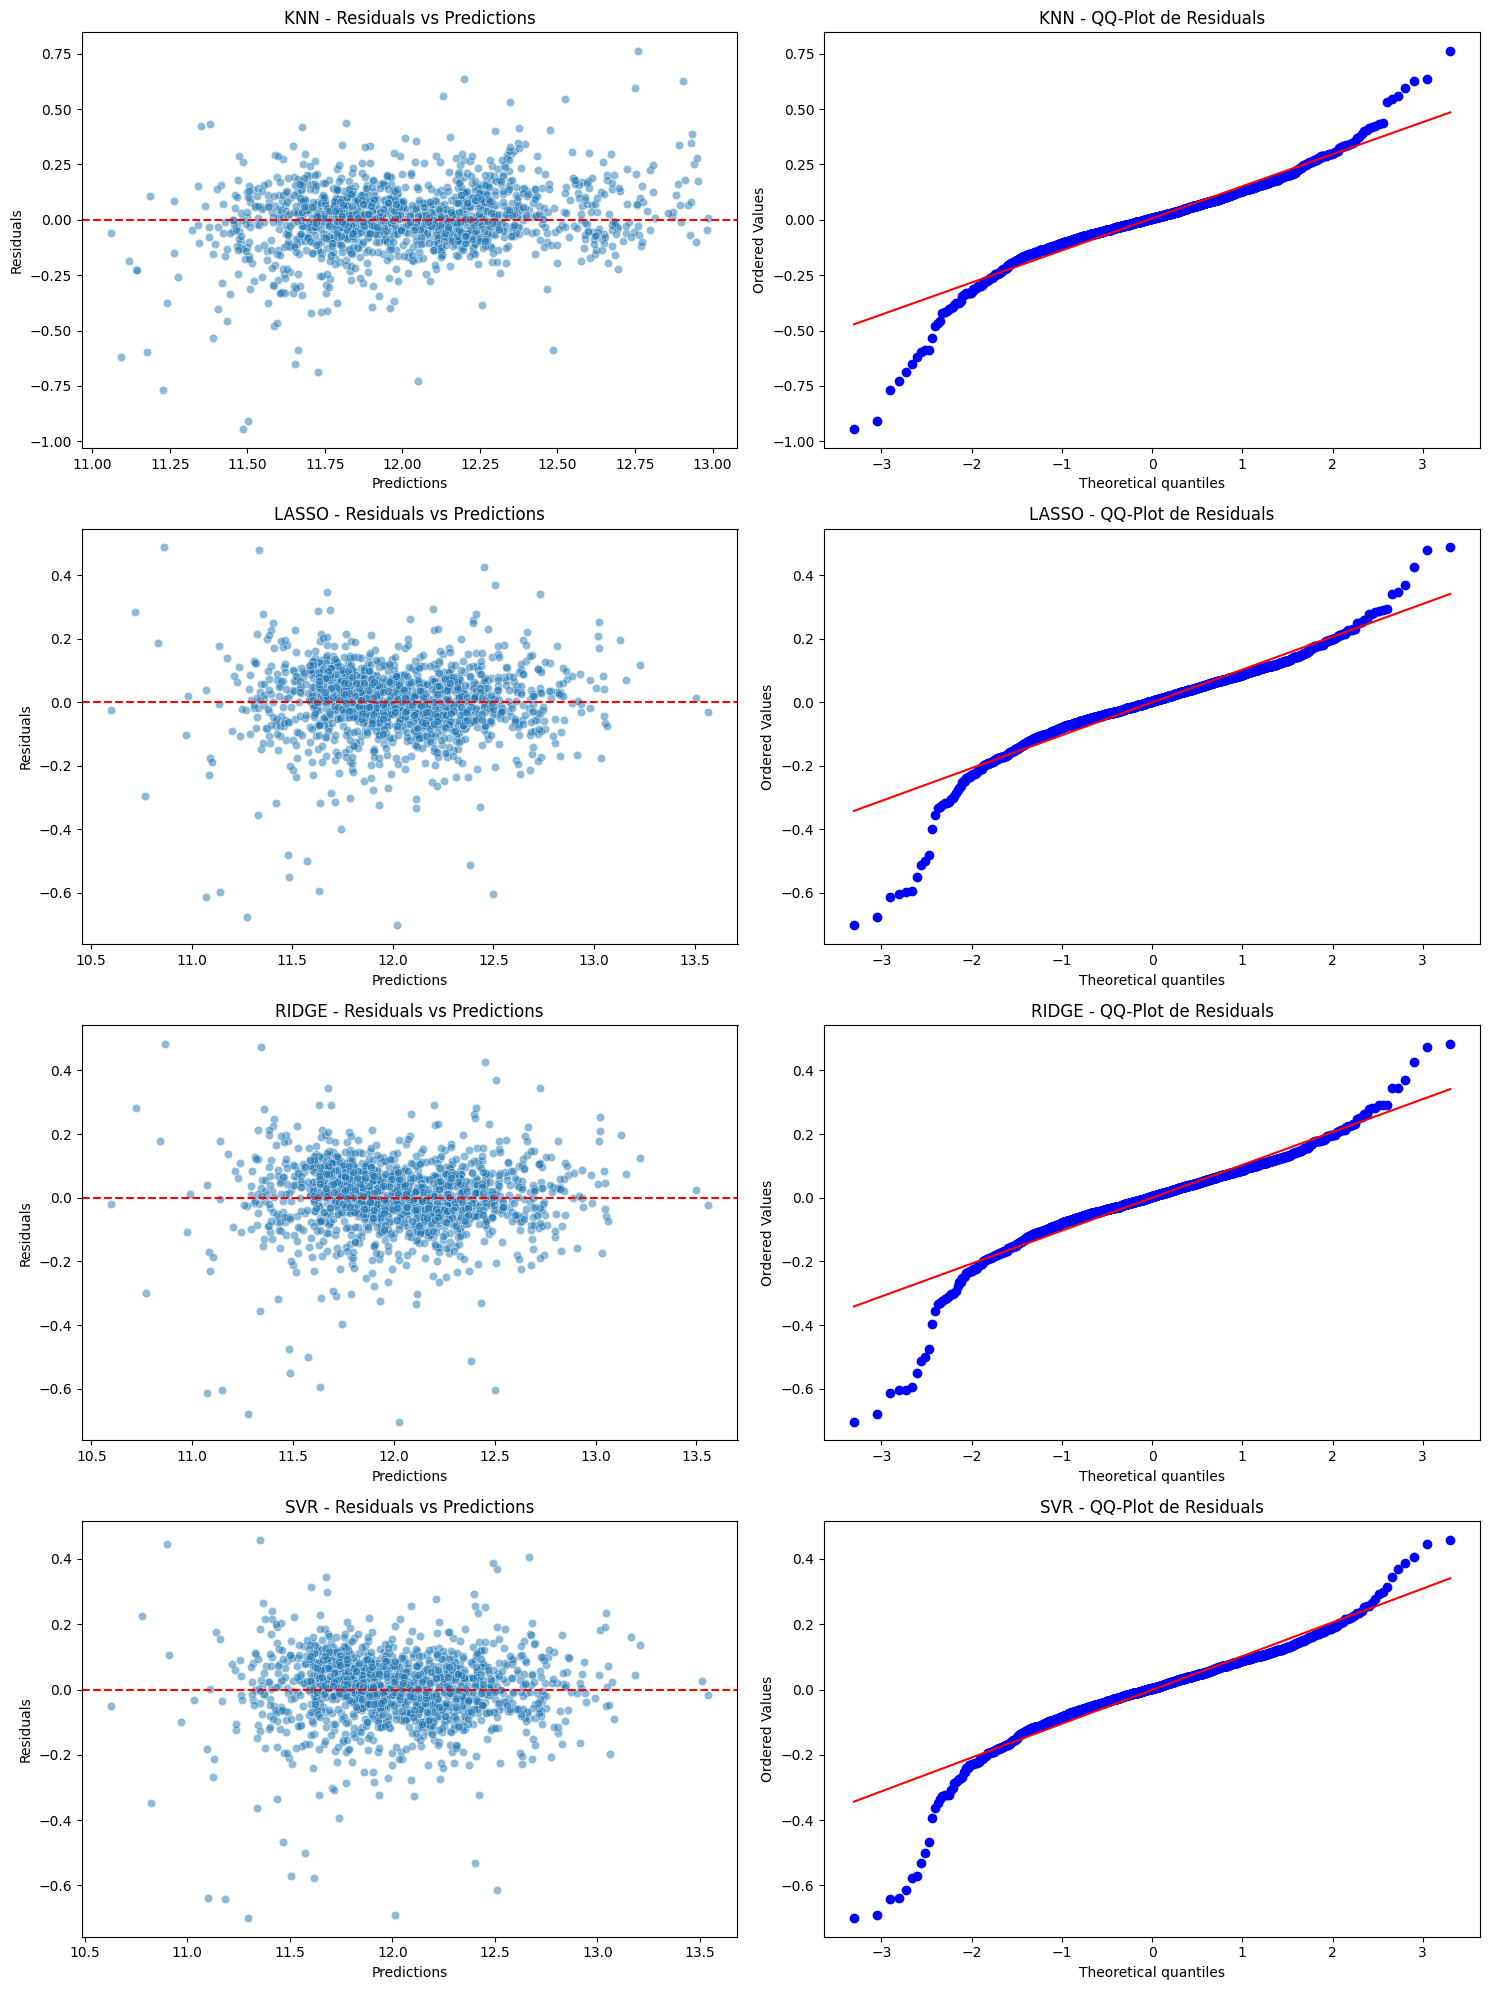

In [4]:
plot_residuals_analysis(models, X_train, y_train)

These plots reveal some crucial information. In the plots on the right, we can see that all our models tend to overpredict house prices (errors in the bottom-left) and are less likely to underpredict (errors in the upper-right).

One initial idea might be to average the predictions of all models to potentially reduce the error. However, because the errors across all models are very similar, it suggests that the predictions are highly correlated and share nearly the same information. As a result, simply averaging them may not lead to a significant improvement.

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001899 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7582
[LightGBM] [Info] Number of data points in the train set: 1308, number of used features: 125
[LightGBM] [Info] Start training from score 12.026915
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

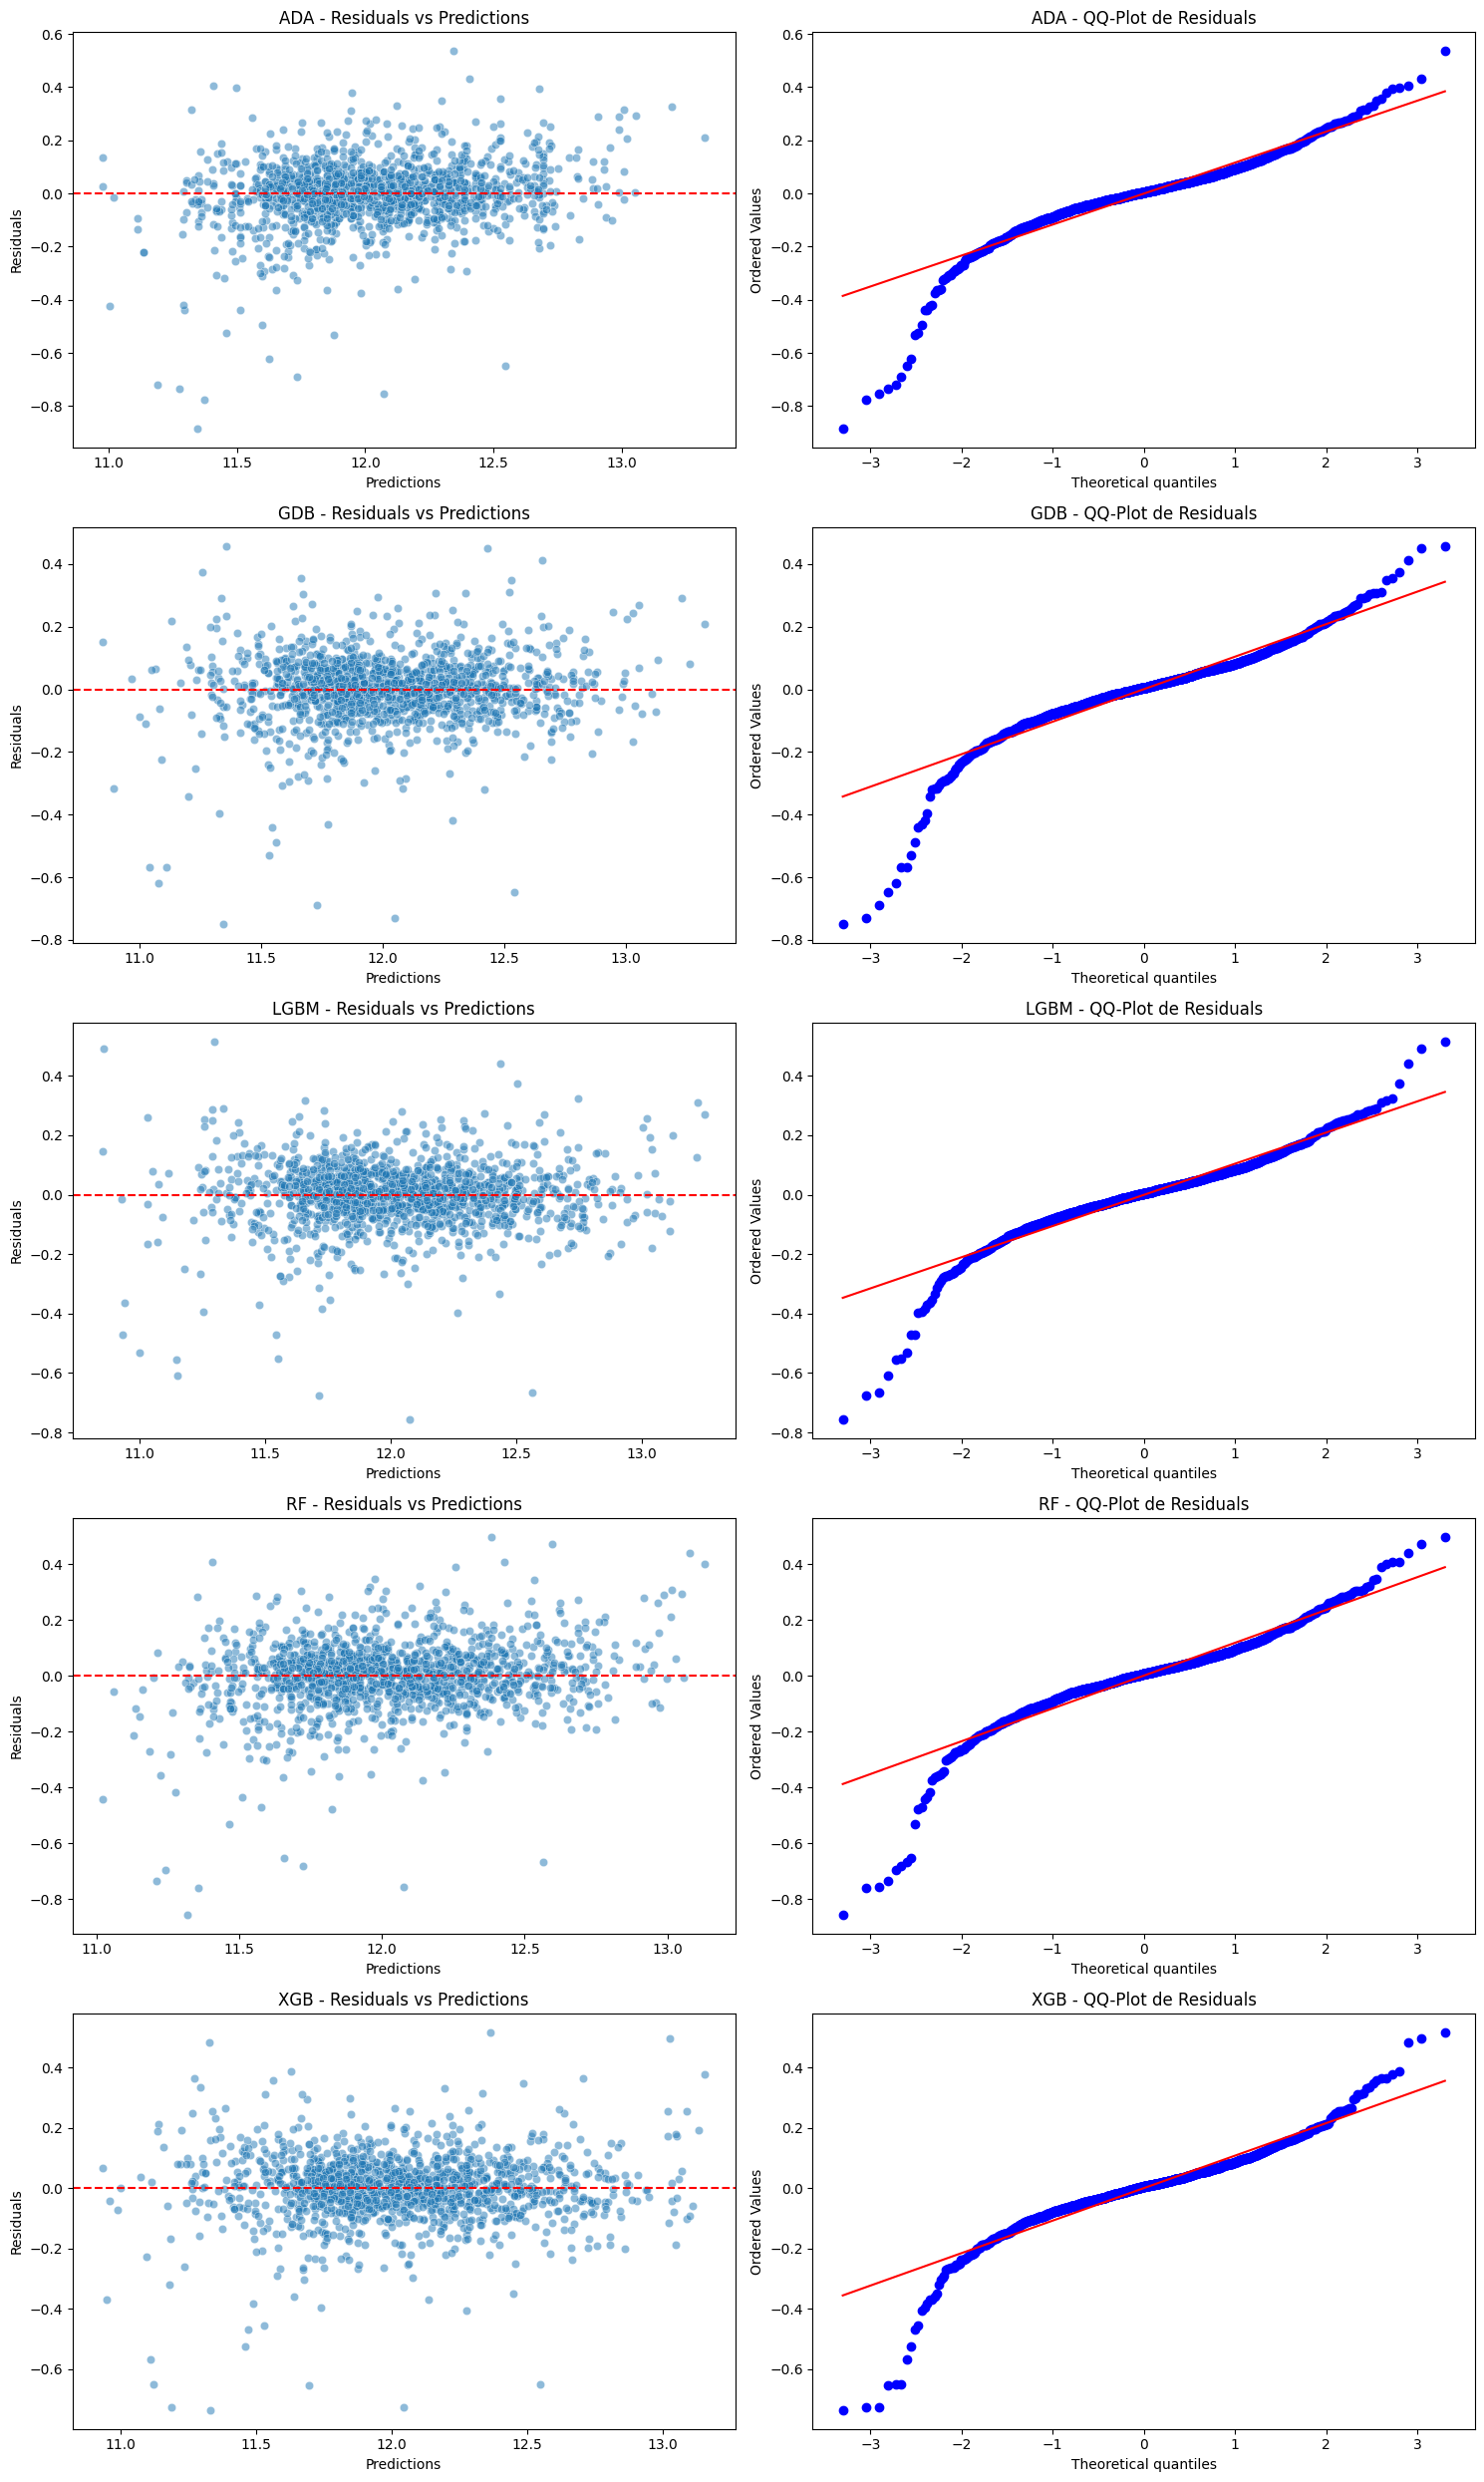

In [5]:
X = pd.read_csv('..//data//preprocessed_data//train_fe_nonlinear.csv')
X = X.iloc[:, 1:]
y = X.pop('SalePrice')
plot_residuals_analysis(non_linear, X, y)

# Stackers
Here we will use two different approaches.
HardVotter:Consist of predicting the values of the test using the predictions of a base of models, by averaging the outputs of the models
Stacking: Does the same but instead of using the average it introduces another model to predict the results, this addition of the model is known as meta or blender model (Can be any regression model).



In [6]:
class HardVotter:
    def __init__(self, base_models, n_folds=5):
        self.base_models = base_models  
        self.n_folds = n_folds  
        self.base_models_ = {}  
        self.oof_preds_ = None  
        self.y_train_ = None  

    def fit(self):
        self.base_models_ = {name: [] for name in self.base_models}  
        
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=2025)

        out_of_fold_preds = np.zeros((0, len(self.base_models)))  

        # Cargar datasets una sola vez
        df_linear = pd.read_csv('../data/preprocessed_data/train_processed.csv')
        df_non_linear = pd.read_csv('../data/preprocessed_data/train_fe_nonlinear.csv')

        for i, (name, model) in enumerate(self.base_models.items()):
            
            if name in ['svr', 'ridge', 'knn', 'lasso', 'linear']:
                df = df_linear
            else:
                df = df_non_linear

            y_train = df['SalePrice'].values
            X_train = df.drop(columns=['SalePrice'])
            X_train = X_train.iloc[:, 1:]

            if self.y_train_ is None:  
                self.y_train_ = y_train
            
            if out_of_fold_preds.shape[0] == 0:
                out_of_fold_preds = np.zeros((X_train.shape[0], len(self.base_models)))

            for train_idx, hold_idx in kfold.split(X_train, y_train):
                model_copy = clone(model)
                model_copy.fit(X_train.iloc[train_idx], y_train[train_idx])
                
                self.base_models_[name].append(model_copy)  
                model_preds = model_copy.predict(X_train.iloc[hold_idx])
                out_of_fold_preds[hold_idx, i] = model_preds

        self.oof_preds_ = out_of_fold_preds
        return self

    def predict(self):
        meta_features = []

        X_test_processed = pd.read_csv('../data/preprocessed_data/test_processed.csv')
        X_test_nonlinear = pd.read_csv('../data/preprocessed_data/test_fe_nonlinear.csv')

        for name, models in self.base_models_.items():
            if name in ['svr', 'ridge', 'knn', 'lasso', 'linear']:
                X_test = X_test_processed.iloc[:, 1:]
            else:
                X_test = X_test_nonlinear.iloc[:, 1:]

            preds = np.column_stack([model.predict(X_test) for model in models]).mean(axis=1)
            meta_features.append(preds)

        meta_features = np.column_stack(meta_features)
        final_preds = np.mean(meta_features, axis=1)  # Se promedian todas las predicciones
        return pd.Series(np.expm1(final_preds), name='SalePrice')
    
    def validate(self):
        if self.oof_preds_ is None or self.y_train_ is None:
            raise ValueError('Train the model before the validation is applied...')

        mse_scores = []
        for name, models in self.base_models_.items():
            avg_model = clone(models[0])  # Se toma un modelo de referencia para cross_val_score
            scores = cross_val_score(avg_model, self.oof_preds_, self.y_train_, cv=self.n_folds, scoring='neg_mean_squared_error')
            mse_scores.append(-scores.mean())

        mse_avg = np.mean(mse_scores)
        print(f'MSE promedio en cv={self.n_folds}: {mse_avg}')
        return mse_avg
    

base_models_dict = {
    'svr': SVR(**models_params['svr']),
    'ridge': Ridge(**models_params['ridge']),
    'rf': RandomForestRegressor(**models_params['rf']),
    'lgb': lgb.LGBMRegressor(**models_params['lgbm']),
    'gdb': GradientBoostingRegressor(**models_params['gdb']),
    'knn': KNeighborsRegressor(**models_params['knn']),
    'lasso': Lasso(**models_params['lasso']),
    'xgb': XGBRegressor(**models_params['xgb'])

}

hard_votter = HardVotter(base_models=base_models_dict).fit()
hard_votter_preds = hard_votter.predict()

mse_hard_votter = hard_votter.validate()
print(f'The mse of the Hard Votter of {base_models_dict.keys()} with cv = 5 is: {mse_hard_votter}')

joblib.dump(hard_votter, '..//data//models_trained//hard_votter.pkl')
print('Model saved!')

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001454 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7408
[LightGBM] [Info] Number of data points in the train set: 1163, number of used features: 122
[LightGBM] [Info] Start training from score 12.025571
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

c:\Users\javie\OneDrive\Escritorio\HousePrediction\HousingPrediction\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.883e+00, tolerance: 1.855e-02
  model = cd_fast.enet_coordinate_descent(
c:\Users\javie\OneDrive\Escritorio\HousePrediction\HousingPrediction\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.170e+00, tolerance: 1.826e-02
  model = cd_fast.enet_coordinate_descent(
c:\Users\javie\OneDrive\Escritorio\HousePrediction\HousingPrediction\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increa

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000115 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 1163, number of used features: 8
[LightGBM] [Info] Start training from score 12.021267
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

c:\Users\javie\OneDrive\Escritorio\HousePrediction\HousingPrediction\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\Users\javie\OneDrive\Escritorio\HousePrediction\HousingPrediction\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\javie\OneDrive\Escritorio\HousePrediction\HousingPrediction\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\Users\javie\OneDrive\Escritorio\HousePrediction\HousingPrediction\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000129 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 1163, number of used features: 8
[LightGBM] [Info] Start training from score 12.032419
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

c:\Users\javie\OneDrive\Escritorio\HousePrediction\HousingPrediction\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\Users\javie\OneDrive\Escritorio\HousePrediction\HousingPrediction\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.848e+00, tolerance: 1.884e-02
  model = cd_fast.enet_coordinate_descent(
c:\Users\javie\OneDrive\Escritorio\HousePrediction\HousingPrediction\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.652e+00, tolerance: 1.794e-02
  model = cd_fa

MSE promedio en cv=5: 0.012318072212744956
The mse of the Hard Votter of dict_keys(['svr', 'ridge', 'rf', 'lgb', 'gdb', 'knn', 'lasso', 'xgb']) with cv = 5 is: 0.012318072212744956
Model saved!


# Making Predictions

Using the make_submission function, we get the format asked by kaggle in order to create a submission csv which is saved on the prediction directory.

In [7]:
hard_votter = make_submission(hard_votter_preds, name = 'HardVottingModel')
hard_votter.head()

,Id,SalePrice
0,1461,119193.829462460
1,1462,157771.974860651
2,1463,182358.541225746
3,1464,193305.171130335
4,1465,189608.494282223


In [ ]:
class Stacking:
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models  
        self.meta_model = meta_model  
        self.n_folds = n_folds  
        self.base_models_ = {}  
        self.meta_model_ = None  
        self.oof_preds_ = None  
        self.y_train_ = None  

    def fit(self):
        self.base_models_ = {name: [] for name in self.base_models}  
        self.meta_model_ = clone(self.meta_model)
        
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=2025)

        out_of_fold_preds = np.zeros((0, len(self.base_models)))  

        #Out of the loop in order to read em once
        df_linear = pd.read_csv('../data/preprocessed_data/train_processed.csv')
        df_non_linear = pd.read_csv('../data/preprocessed_data/train_fe_nonlinear.csv')

        for i, (name, model) in enumerate(self.base_models.items()):
            
            if name in ['svr', 'ridge', 'knn', 'lasso']:
                df = df_linear
            else:
                df = df_non_linear

            y_train = df['SalePrice'].values
            X_train = df.drop(columns=['SalePrice'])
            X_train = X_train.iloc[:, 1:]

            if self.y_train_ is None:  
                self.y_train_ = y_train
            
            
            if out_of_fold_preds.shape[0] == 0:
                out_of_fold_preds = np.zeros((X_train.shape[0], len(self.base_models)))

            for train_idx, hold_idx in kfold.split(X_train, y_train):
                model_copy = clone(model)
                model_copy.fit(X_train.iloc[train_idx], y_train[train_idx])
                
                self.base_models_[name].append(model_copy)  
                model_preds = model_copy.predict(X_train.iloc[hold_idx])
                out_of_fold_preds[hold_idx, i] = model_preds

        self.oof_preds_ = out_of_fold_preds
        self.meta_model_.fit(out_of_fold_preds, self.y_train_)
        return self

    def predict(self):
        meta_features = []

        X_test_processed = pd.read_csv('../data/preprocessed_data/test_processed.csv')
        X_test_nonlinear = pd.read_csv('../data/preprocessed_data/test_fe_nonlinear.csv')

        for name, models in self.base_models_.items():
            if name in ['svr', 'ridge', 'knn', 'lasso']:
                X_test = X_test_processed.iloc[:, 1:]
            else:
                X_test = X_test_nonlinear.iloc[:, 1:]

            preds = np.column_stack([model.predict(X_test) for model in models]).mean(axis=1)
            meta_features.append(preds)

        meta_features = np.column_stack(meta_features)
        final_preds = self.meta_model_.predict(meta_features)
        return pd.Series(np.expm1(final_preds), name='SalePrice')
    
    def validate(self):
        if self.oof_preds_ is None or self.y_train_ is None:
            raise ValueError('Train the model before the validation is applied...')
        
        mse = -np.mean(cross_val_score(self.meta_model_, self.oof_preds_, self.y_train_, cv=5, scoring='neg_mean_squared_error'))
        print(f'MSE on cv = 5: {mse}')
        return mse


# Base Learners
base_learners_dict = {
    'gdb': GradientBoostingRegressor(**models_params['gdb']),
    'ridge': Ridge(**models_params['ridge']),
    'svr': SVR(**models_params['svr']),
    'lgbm': lgb.LGBMRegressor(**models_params['lgbm'])
    
}
meta_candidates = [
    ('lasso', Lasso(**models_params['lasso']))
]

#Searching for the best blender
results = {}
for name, meta_model in meta_candidates:
    print(f'\nEvaluating: {name}')
    stacker = Stacking(base_models=base_learners_dict, meta_model=meta_model)
    stacker.fit()
    joblib.dump(stacker, f'..//data//models_trained//stacker_{name}.pkl')
    print('Model saved!')
    
    mse = stacker.validate()
    results[name] = mse
    print(f'MSE para {name}: {mse}')

print('\nFinal Results:')
for name, score in sorted(results.items(), key=lambda x: x[1]):
    print(f'{name}: {score}')



Evaluating: lasso
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001501 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7408
[LightGBM] [Info] Number of data points in the train set: 1163, number of used features: 122
[LightGBM] [Info] Start training from score 12.025571
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

# Winner Prediction

In [ ]:
lasso_stacker = stacker.predict()
lasso_stacker_sub = make_submission(lasso_stacker, 'lasso_stacker')

# Conclusion

Stacking provided the best results by far. However, there is still room for improvement by experimenting with different combinations of meta-models and base learners. It's important to note that the stacking process is highly computationally expensive. Due to this limitation, I was unable to test many configurations. In the near future, I plan to refine this ensemble model further. Additionally, I aim to explore neural network architectures and dimensionality reduction techniques on this dataset to enhance the final ensemble model's performance. These developments will be presented in future notebooks.



